## TODO
In this assignment, you need to train regression models on Beijing PM2.5 dataset in winter of 2014.

1. You have to implement
- a Linear (Polynomial) regressor
- a Random Forest regressor
3. You need to show a residual plot for each of your model on both training data and testing data.
4. $R^2$ score of at least one model need to be larger than 0.72 on testing data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# inline plotting instead of popping out
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv',
    sep=',')

# Do not modify
df = df.drop(['cbwd'], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how='any')  # drop samples who has nan feature

# Do not modify
idx = np.logical_or(
    np.logical_and(df['year'].values == 2014, df['month'].values < 3),
    np.logical_and(df['year'].values == 2013, df['month'].values == 12))
X = df.loc[idx].drop('pm2.5', axis=1)
y = df.loc[idx]['pm2.5'].values
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0


plot all the pairwise join distributions related to 'pm2.5'

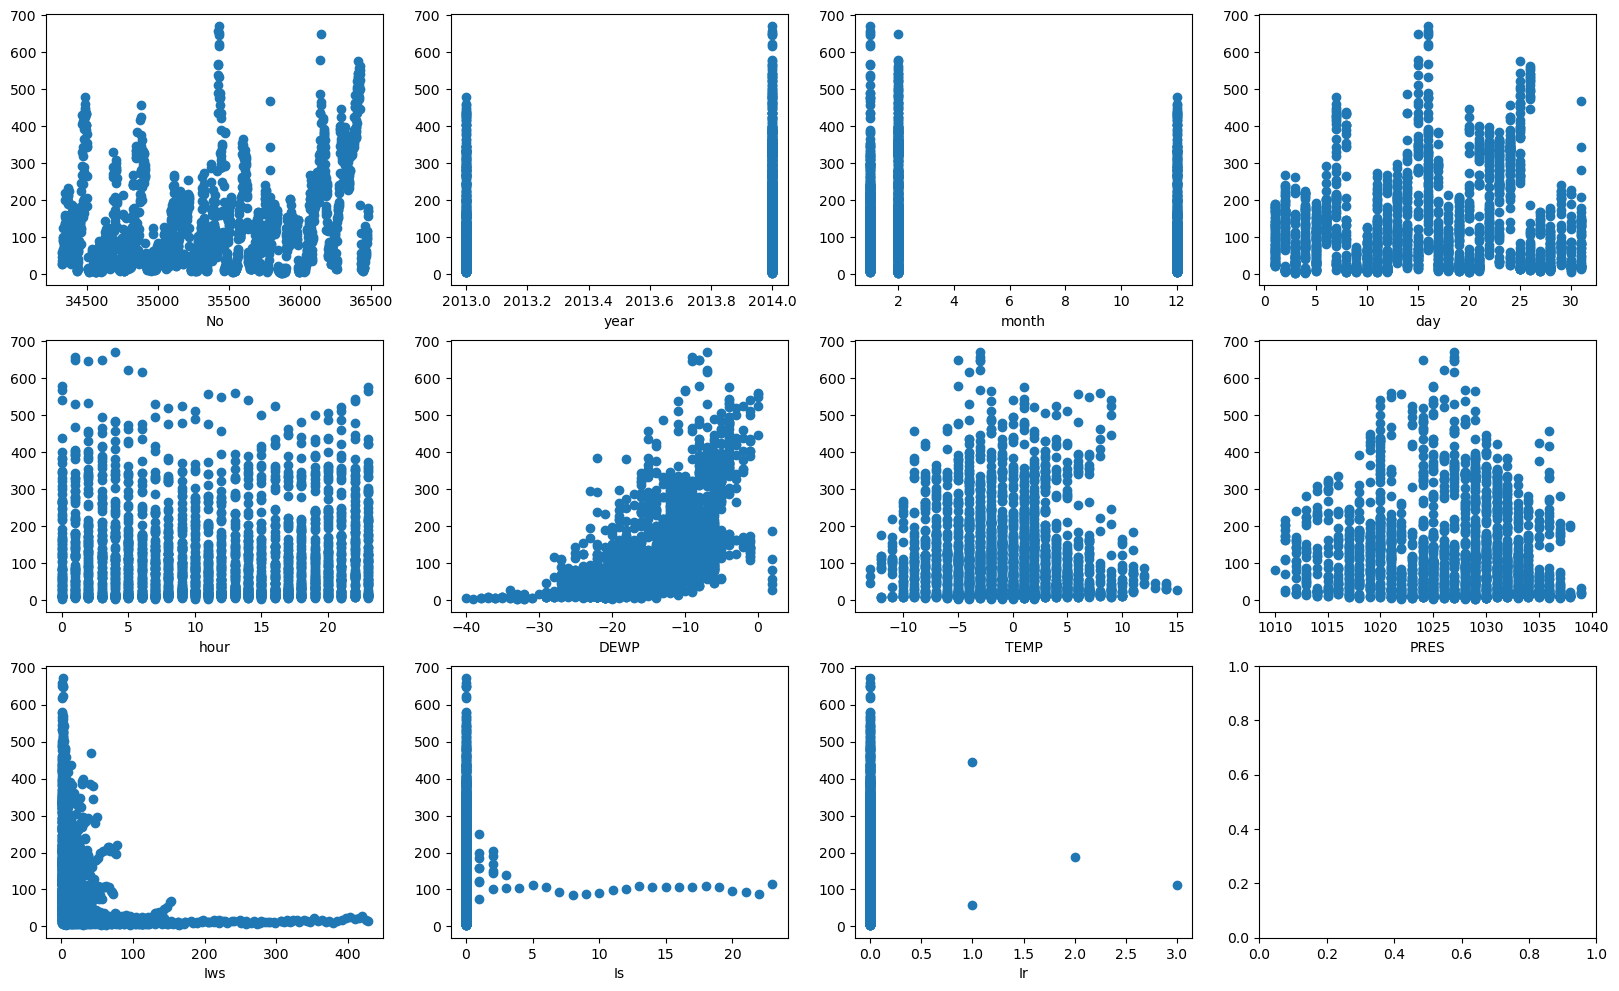

In [3]:
x_vars = ['No', 'year', 'month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is','Ir']

_, subplot_arr = plt.subplots(3, 4, figsize=(20, 12))
for idx, x_var in enumerate(x_vars):
    x_idx = idx // 4
    y_idx = idx % 4
    subplot_arr[x_idx, y_idx].scatter(X[x_var], y)
    subplot_arr[x_idx, y_idx].set_xlabel(x_var)

plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])


# Standardization
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

#Training data points: 1491
#Testing data points: 639


## Linear (Polynomial) Regression

In [5]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.00007, n_iter=40, random_state=1,n_cell=20):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=n_cell) 
        self.cost_ = []
        self.n_cell = n_cell
        
    def fit(self, X, y):
 
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [6]:
def plot_resid(y_train_pred,y_train, y_test_pred, y_test):
    plt.scatter(
        y_train_pred,
        y_train_pred - y_train,
        c='blue',
        marker='o',
        label='Training data')
    plt.scatter(
        y_test_pred,
        y_test_pred - y_test,
        c='lightgreen',
        marker='s',
        label='Test data')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
    plt.xlim([-10, 50])
    plt.tight_layout()
    plt.show()

[Linear]
#Features: 11
MSE train: 8220.34, test: 8724.54
R^2 train: 0.48, test: 0.44


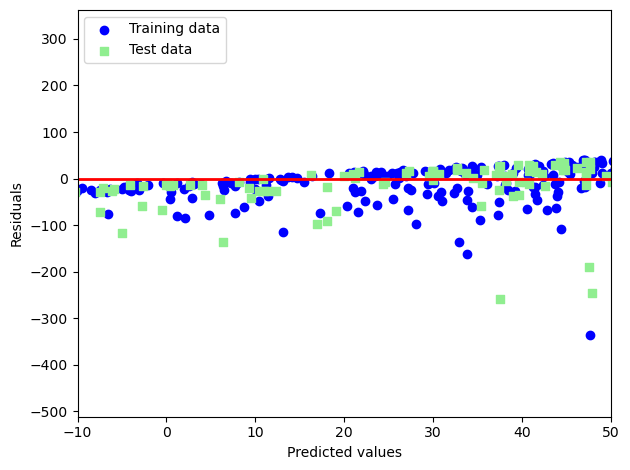

In [7]:
lr_regr = LinearRegressionGD(n_iter=50,n_cell = X_train_std.shape[1]+1)
print('[Linear]')
print('#Features: %d' % X_train_std.shape[1])
lr_regr = lr_regr.fit(X_train_std, y_train)
y_train_pred_lr = lr_regr.predict(X_train_std)
y_test_pred_lr = lr_regr.predict(X_test_std)
print('MSE train: %.2f, test: %.2f' %
       (mean_squared_error(y_train, y_train_pred_lr),
        mean_squared_error(y_test, y_test_pred_lr)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred_lr),
                                        r2_score(y_test, y_test_pred_lr)))
plot_resid(y_train_pred_lr,y_train, y_test_pred_lr, y_test)


[Quadratic]
#Features: 78
MSE train: 8650.82, test: 9756.58
R^2 train: 0.46, test: 0.37


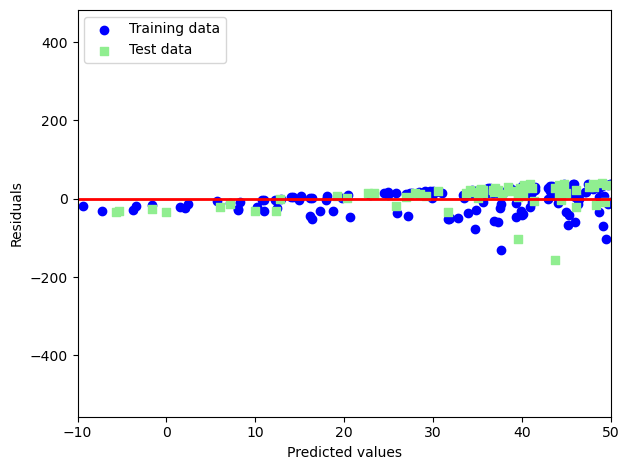

In [8]:
quadratic = PolynomialFeatures(degree=2)

print('\n[Quadratic]')
X_quad_train = quadratic.fit_transform(X_train_std)
X_quad_test = quadratic.fit_transform(X_test_std)

print('#Features: %d' % X_quad_train.shape[1])

quad_regr = LinearRegressionGD(eta = 0.00000012,n_iter = 5000,n_cell = X_quad_train.shape[1]+1)
quad_regr = quad_regr.fit(X_quad_train, y_train)
y_train_pred_quad = quad_regr.predict(X_quad_train)
y_test_pred_quad = quad_regr.predict(X_quad_test)


print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred_quad),
       mean_squared_error(y_test, y_test_pred_quad)))


print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred_quad),
                                       r2_score(y_test, y_test_pred_quad)))
plot_resid(y_train_pred_quad,y_train, y_test_pred_quad, y_test)


[Cubic]
#Features: 364
MSE train: 27448.74, test: 26881.83
R^2 test: -0.73, test: -0.73


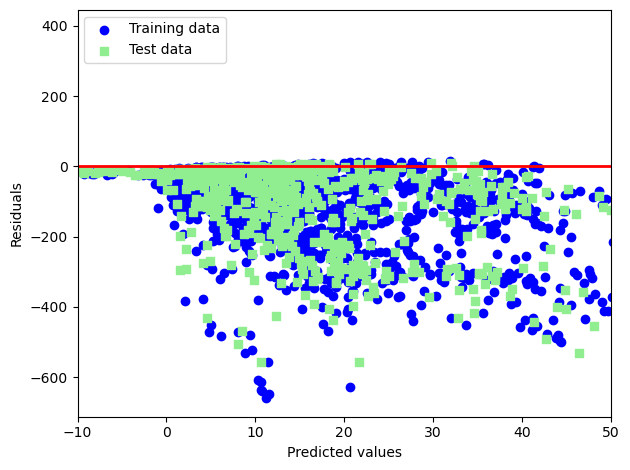

In [9]:
cubic = PolynomialFeatures(degree=3)

print('\n[Cubic]')
X_cubic_train = cubic.fit_transform(X_train_std)
X_cubic_test = cubic.fit_transform(X_test_std)
cubic_regr = LinearRegressionGD(eta = 0.000000001,n_iter = 5000,n_cell = X_cubic_train.shape[1]+1)

print('#Features: %d' % X_cubic_train.shape[1])
cubic_regr = cubic_regr.fit(X_cubic_train, y_train)
y_train_pred_cubic = cubic_regr.predict(X_cubic_train)
y_test_pred_cubic = cubic_regr.predict(X_cubic_test)


print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred_cubic),
       mean_squared_error(y_test, y_test_pred_cubic)))


print('R^2 test: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred_cubic),
                                       r2_score(y_test, y_test_pred_cubic)))

plot_resid(y_train_pred_cubic,y_train, y_test_pred_cubic, y_test)

## Random Forest Regression

MSE train: 313.73, test: 1757.49
R^2 train: 0.98, test: 0.89


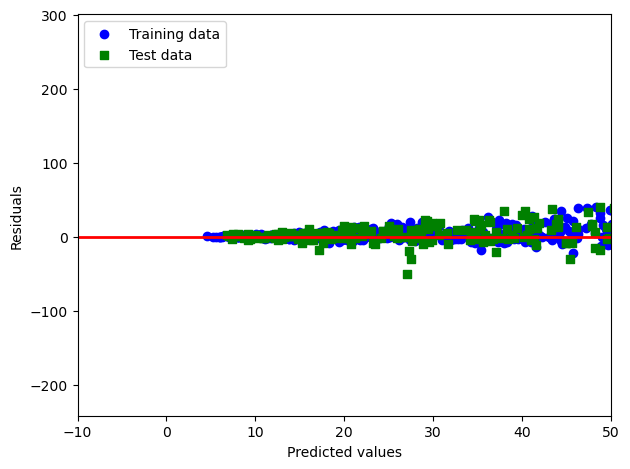

In [11]:
forest = RandomForestRegressor(
    n_estimators=10, criterion='squared_error', random_state=1, n_jobs=-1)
forest.fit(X_train_std, y_train)
y_train_pred_fr = forest.predict(X_train_std)
y_test_pred_fr = forest.predict(X_test_std)

print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred_fr),
       mean_squared_error(y_test, y_test_pred_fr)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred_fr),
                                       r2_score(y_test, y_test_pred_fr)))

# Residual plot
plt.scatter(
    y_train_pred_fr,
    y_train_pred_fr - y_train,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred_fr, y_test_pred_fr - y_test, c='green', marker='s', label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()